In [2]:
from sklearn.externals import joblib
from ctapipe.utils import get_dataset_path
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../')
import reco.calib_dl0_to_dl1 as calib
import reco.reco_dl1_to_dl2 as reco
import reco.plot_dl2 as lstplot
from

/Users/thomasvuillaume/anaconda/envs/cta-dev/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#Import a simtelarray file with data
PATH = "/scratch/bernardos/LST1/Gamma/Point_Prod-3_LaPalma_flashcam-prod3j/"
datafile = PATH+"gamma_20deg_0deg_run11716___cta-prod3-lapalma-2147m-LaPalma-FlashCam.simtel.gz"

print(datafile)

/scratch/bernardos/LST1/Gamma/Point_Prod-3_LaPalma_flashcam-prod3j/gamma_20deg_0deg_run11716___cta-prod3-lapalma-2147m-LaPalma-FlashCam.simtel.gz


In [3]:
#Select LST1 events from the file, calibrate them, extract hillas and timing parameters.
#DL0 -> DL1 

data = calib.get_events(datafile,False,True)

EVENT_ID:  609 TELS:  {1} MC Energy: 0.3850012719631195 TeV


../reco/calib_dl0_to_dl1.py:154: RuntimeWarning: invalid value encountered in log10
  log10pixelHGsignal[str(geom)].extend(np.log10(signals))
/afs/ciemat.es/user/b/bernardos/GitHub/ctapipe/ctapipe/image/hillas.py:565: RuntimeWarning: invalid value encountered in sqrt
  width = np.sqrt((vy2 + vx2 - z) / 2.0)


EVENT_ID:  240904 TELS:  {1} MC Energy: 0.10447962582111359 TeV
EVENT_ID:  479306 TELS:  {1} MC Energy: 0.07286497205495834 TeV
EVENT_ID:  718206 TELS:  {1} MC Energy: 0.1408354490995407 TeV
EVENT_ID:  1013503 TELS:  {1} MC Energy: 0.027403896674513817 TeV
EVENT_ID:  1235701 TELS:  {1} MC Energy: 0.08158047497272491 TeV
EVENT_ID:  1473402 TELS:  {1} MC Energy: 0.019133590161800385 TeV
EVENT_ID:  1709700 TELS:  {1} MC Energy: 0.01722150482237339 TeV
EVENT_ID:  1933202 TELS:  {1} MC Energy: 1.5353238582611084 TeV
EVENT_ID:  2211001 TELS:  {1} MC Energy: 0.04507935792207718 TeV
EVENT_ID:  2493706 TELS:  {1} MC Energy: 0.04200652614235878 TeV


In [29]:
#Take a look at the parameters extracted from the simtelarray file:
print(data.keys())

Index(['obs_id', 'event_id', 'mc_energy', 'mcAlt', 'mc_az', 'mc_core_x', 'mc_core_y',
       'mcHfirst', 'mc_type', 'gps_time', 'width', 'length', 'w/l', 'phi', 'psi',
       'r', 'x', 'y', 'intensity', 'skewness', 'kurtosis', 'mcAlttel',
       'mc_az_tel', 'impact', 'mc_x_max', 'time_gradient', 'intercept', 'src_x',
       'src_y', 'disp', 'hadroness', 'Erec', 'Disprec', 'src_xrec', 'src_yrec',
       'Hadrorec'],
      dtype='object')


Text(0.5,0,'$log_{10} mc_energy$ (MeV)')

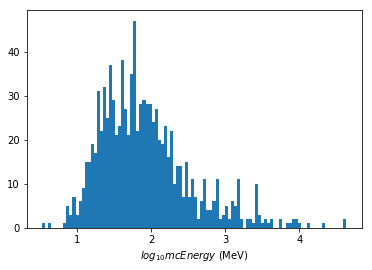

In [28]:
#We can plot some distributions:
plt.hist(data['mc_energy'],bins=100) #Log10(Energy) in MeV
plt.xlabel('$log_{10} mc_energy$ (MeV)')

Text(0.5,0,'$log_{10} intensity$')

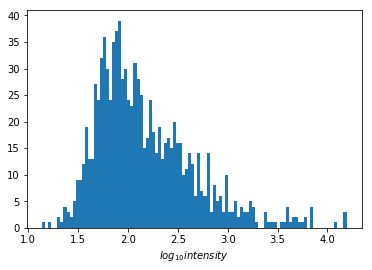

In [27]:
plt.hist(data['intensity'],bins=100) #Log10(intensity(size))
plt.xlabel('$log_{10} intensity$')

Text(0.5,0,'width (º)')

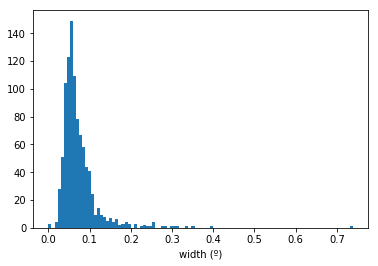

In [26]:
plt.hist(data['width'],bins=100) #Width in deg.
plt.xlabel('width (º)')

Text(0.5,0,'length (º)')

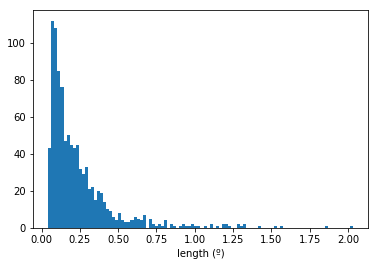

In [24]:
plt.hist(data['length'],bins=100) #Length in deg. 
plt.xlabel('length (º)')

Text(0,0.5,'y (m)')

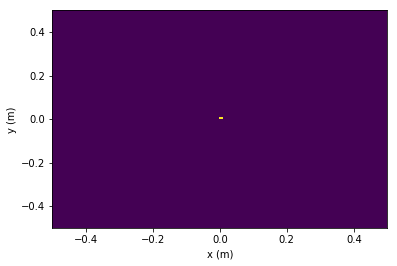

In [25]:
#See the source position: Point gammas or diffuse gammas? (camera coordinates)
plt.hist2d(data['src_x'],data['src_y'],bins=100)
plt.xlabel('x (m)')
plt.ylabel('y (m)')

Text(0,0.5,'y (m)')

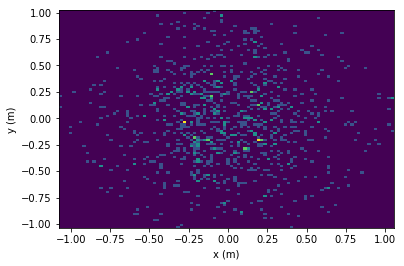

In [23]:
#Position of the hillas ellipse center of gravity (camera coordinates)
plt.hist2d(data['x'],data['y'],bins=100)
plt.xlabel('x (m)')
plt.ylabel('y (m)')

In [30]:
#Let's train the Random Forests for Reconstruction
#We must have two files, one with dl1 gamma events and other with dl1 proton events
PATH_EVENTS = "/scratch/bernardos/LST1/Events/"
gammafile = PATH_EVENTS+"gamma_events_point.hdf5"
protonfile = PATH_EVENTS+"proton_events.hdf5"
print(gammafile,protonfile)

/scratch/bernardos/LST1/Events/gamma_events_point.hdf5 /scratch/bernardos/LST1/Events/proton_events.hdf5


In [31]:
#Define the features to train the RF:
features = ['intensity',                                                                                  
                'time_gradient',                                                                              
                'width',                                                                                      
                'length',                                                                                     
                'w/l',                                                                                        
                'phi',                                                                                        
                'psi']
print(features)

['intensity', 'time_gradient', 'width', 'length', 'w/l', 'phi', 'psi']


In [13]:
#Train three Random Forests:
#- Two Random Forests Regressors for Energy and Disp(source position) reconstruction
#- One Random Forest Classifier for gamma/hadron separation (uses results from previous RF as new features, Erec, Disprec)

RFreg_Energy,RFreg_Disp,RFcls_GH = reco.buildModels(gammafile,protonfile,features,False)

Given features:  ['intensity', 'time_gradient', 'width', 'length', 'w/l', 'phi', 'psi']
Number of events for training:  397446
Training Random Forest Regressor for Energy Reconstruction...
Random Forest trained!
Training Random Forest Regressor for Disp Reconstruction...
Random Forest trained!
Done!


/afs/ciemat.es/user/b/bernardos/.conda/envs/ctapipe/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Given features:  ['intensity', 'time_gradient', 'width', 'length', 'w/l', 'phi', 'psi']
Number of events for training:  198959
Training Random Forest Regressor for Energy Reconstruction...
Random Forest trained!
Training Random Forest Regressor for Disp Reconstruction...
Random Forest trained!
Done!
Given features:  ['intensity', 'time_gradient', 'width', 'length', 'w/l', 'phi', 'psi', 'Erec', 'Disprec']
Number of events for training:  331879
Training Random Forest Classifier for Gamma/Hadron separation...
Random Forest trained!
Done!


In [37]:
#Now we have the trained RF that we can use to reconstruct our data into dl2 format:
data_dl2 = data
reco.ApplyModels(data,data_dl2,features,RFcls_GH,RFreg_Energy,RFreg_Disp)
print(data_dl2.keys())

Index(['obs_id', 'event_id', 'mc_energy', 'mcAlt', 'mc_az', 'mc_core_x', 'mc_core_y',
       'mcHfirst', 'mc_type', 'gps_time', 'width', 'length', 'w/l', 'phi', 'psi',
       'r', 'x', 'y', 'intensity', 'skewness', 'kurtosis', 'mcAlttel',
       'mc_az_tel', 'impact', 'mc_x_max', 'time_gradient', 'intercept', 'src_x',
       'src_y', 'disp', 'hadroness', 'Erec', 'Disprec', 'src_xrec', 'src_yrec',
       'Hadrorec'],
      dtype='object')


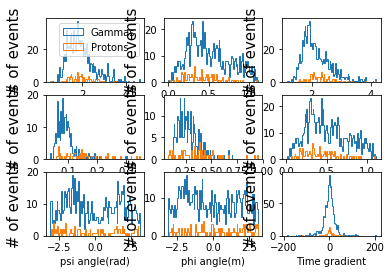

In [38]:
#Lets take a look to the results
lstplot.plot_features(data_dl2)

0.01933060164898719 0.6056633919429704


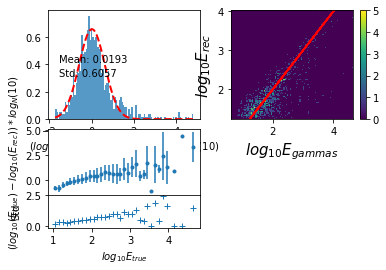

In [39]:
lstplot.plot_E(data_dl2)

0.05978073655669025 0.24232860117888574


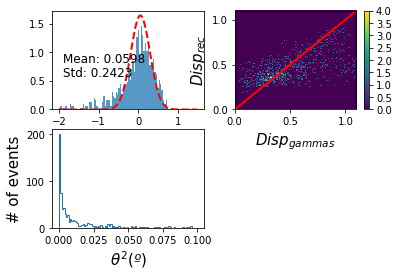

In [41]:
lstplot.plot_Disp(data_dl2)

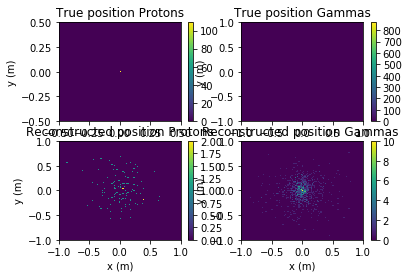

In [40]:
lstplot.plot_pos(data_dl2)

Text(0.5,0,'Hadroness')

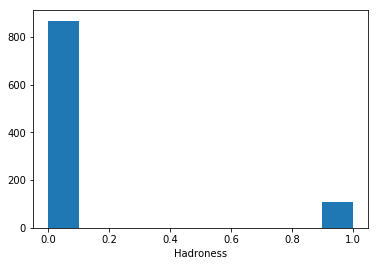

In [42]:
plt.hist(data_dl2['Hadrorec'])
plt.xlabel('Hadroness')

In [43]:
#We can apply a cut in energy and see the results again:
data_dl2 = data_dl2[data_dl2['Erec']>2.699]

0.09917657580097941 0.4752955181407565


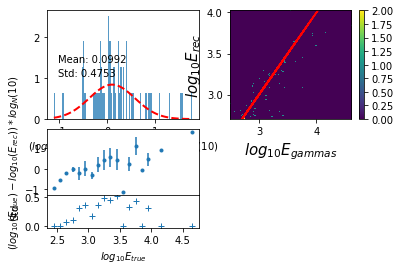

In [44]:
lstplot.plot_E(data_dl2)

0.0255947595899268 0.0984188680013846


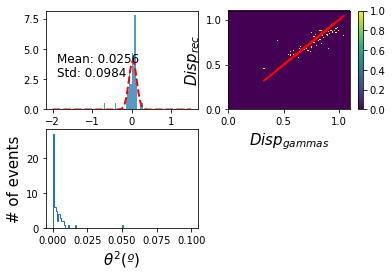

In [45]:
lstplot.plot_Disp(data_dl2)

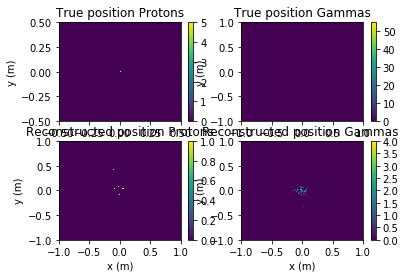

In [46]:
lstplot.plot_pos(data_dl2)

Text(0.5,0,'Hadroness')

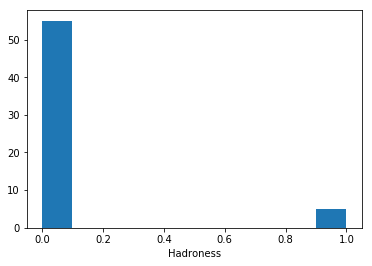

In [47]:
plt.hist(data_dl2['Hadrorec'])
plt.xlabel('Hadroness')